In [1]:
using Pkg 
Pkg.activate(".")

  Activating project at `~/PhD/GaussianProcessNode`


In [2]:
using Revise 
using StableRNGs, GraphPPL,ReactiveMP, RxInfer, Random, Distributions, LinearAlgebra, Plots
using SpecialFunctions, ForwardDiff, Optim
using BenchmarkTools
import KernelFunctions: SqExponentialKernel, Matern52Kernel, with_lengthscale, Kernel, kernelmatrix  
import ReactiveMP: GaussHermiteCubature, approximate_meancov

In [3]:
function generate_cleandata(n, f_gp, c_gp)
    y=Float64[]
    obs = []
    for i=1:n
        temp = c_gp[i] * exp(f_gp[i]) 
        push!(y,temp)
    end
    return y
end

function Params2Natural_Lognormal(dist)
    μ,σ = Distributions.params(dist)
    η1 = μ/σ^2 - 1
    η2 = -1 / (2*σ^2)
    @assert η2 < 0 "η2 must be negative"
    return η1, η2
end

function Natural2Params_Lognormal(η1, η2)
    μ = -(η1 + 1) / (2*(η2))
    σ = sqrt(-1/(2*(η2)))
    return μ, σ
end

Natural2Params_Lognormal (generic function with 1 method)

In [4]:
laguerre_points, laguerre_w = ReactiveMP.gausslaguerre(150)

([0.009606654629409994, 0.050618040450464384, 0.12440536207005143, 0.2309930480366001, 0.3703947273062108, 0.5426260882463105, 0.7477060960351558, 0.985657229147154, 1.2565055526970563, 1.5602807540567545  …  440.12567427830066, 450.7222559626506, 461.83939769807546, 473.5633844141849, 486.0108237670103, 499.34679830016717, 513.8203968206594, 529.8441888122384, 548.2129473049381, 570.9894107735548], [0.024418201596381497, 0.05455943267271721, 0.07963553918231421, 0.09762453340332569, 0.10758335964615703, 0.10964843497281539, 0.10487493354235908, 0.09493868623520238, 0.08178092919451643, 0.06727706960564966  …  7.433520344040009e-191, 1.945438107048278e-195, 3.0391957613403764e-200, 2.6031063087881972e-205, 1.089888489523467e-210, 1.8967057824444117e-216, 1.0747865929765876e-222, 1.3252984528610398e-229, 1.6425052241076186e-237, 2.8104111710854407e-247])

In [5]:
function estimate_MeanOfSufficient_Lognormal(dist, func, nsamples)
    samples = rand(StableRNG(1),dist,nsamples)
    Z = sum(func.(samples)) / nsamples
    E_logx = sum(func.(samples) .* log.(samples)) / (nsamples * Z)
    E_logx² = sum(func.(samples) .* (log.(samples)).^2) / (nsamples * Z)
    return E_logx, E_logx²
end

function estimate_MeanOfSufficient_Lognormal_gausslaguerre(dist, func, points, w)
    WeightFunction_Z = (x) -> pdf(dist,x) * func(x) / exp(-x)
    WeightFunction_logx = (x) -> pdf(dist,x) * func(x) * log(x) / exp(-x)
    WeightFunction_logx² = (x) -> pdf(dist,x) * func(x) * (log(x))^2 / exp(-x)

    Z = dot(w,WeightFunction_Z.(points))
    E_logx = clamp(dot(w,WeightFunction_logx.(points)) / Z,tiny,huge)
    E_logx² = clamp(dot(w,WeightFunction_logx².(points)) / Z,tiny,huge)
    return E_logx, E_logx²
end

estimate_MeanOfSufficient_Lognormal_gausslaguerre (generic function with 1 method)

In [6]:
function estimate_MeanOfSufficient_Normal_gausslaguerre(sign,dist, func, points, w)
    WeightFunction_Z = (x) -> pdf(dist,x*sign) * func(x*sign) / exp(-x)
    WeightFunction_x = (x) -> sign*pdf(dist,sign*x) * func(sign*x) * x / exp(-x)
    WeightFunction_x² = (x) -> pdf(dist,sign*x) * func(sign*x) * x^2 / exp(-x)

    Z = dot(w,WeightFunction_Z.(points))
    E_x = clamp(dot(w,WeightFunction_x.(points)) / Z,-Inf,huge)
    v = clamp(dot(w,WeightFunction_x².(points)) / Z - E_x^2,tiny,huge)
    return E_x, v
end

estimate_MeanOfSufficient_Normal_gausslaguerre (generic function with 1 method)

In [10]:
N = 500; 

l_amplitude = 1.; σ_amplitude = 1.
l_carrier   = 0.01; σ_carrier = 0.5

mean_amplitude = (x) -> 0;
mean_carrier   = (x) -> 0.;

kernel_amplitude(l)   =  σ_amplitude * with_lengthscale(Matern52Kernel(),l) 
kernel_carrier(l)     =  σ_carrier * with_lengthscale(Matern52Kernel(),l)

tmin,tmax = 0., 5.0
time_range = collect(range(tmin, tmax; length=N));
Cov_amplitude = kernelmatrix(kernel_amplitude(l_amplitude),time_range,time_range) + 1e-7*I;
Cov_carrier   = kernelmatrix(kernel_carrier(l_carrier),time_range,time_range) + 1e-7I;
gp_amplitude  = MvNormal(mean_amplitude.(time_range), Cov_amplitude)
gp_carrier    = MvNormal(mean_carrier.(time_range), Cov_carrier)
amplitude_gt = rand(StableRNG(1133),gp_amplitude)
carrier_gt   = rand(StableRNG(11), gp_carrier)


#Generate data 
y_data_synthetic = generate_cleandata(N,amplitude_gt,carrier_gt);
slicedim(dim) = (a) -> map(e -> e[dim], a);

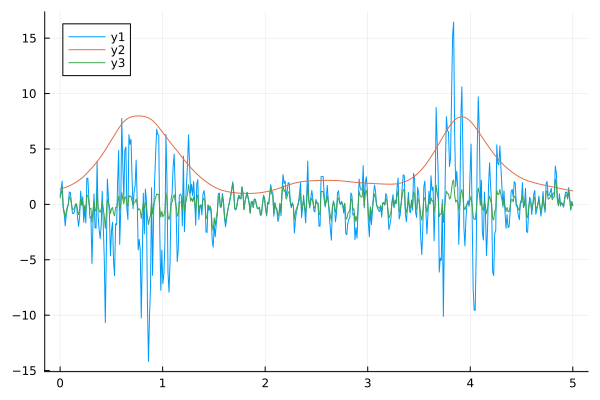

In [11]:
plot(time_range, y_data_synthetic)
plot!(time_range,exp.(amplitude_gt))
plot!(time_range,carrier_gt)

In [12]:
#Exponentiate function 
struct MyExponential end

@node MyExponential Deterministic [ y, x ]   ## x: input,  y: output


@rule MyExponential(:y, Marginalisation) (m_x::UnivariateGaussianDistributionsFamily,) = begin 
    return LogNormal(mean(m_x), std(m_x))
end
@rule MyExponential(:x, Marginalisation) (m_y::LogNormal,) = begin 
    μ, σ = Distributions.params(m_y)
    return NormalMeanVariance(μ - σ^2,σ^2)
end

@marginalrule MyExponential(:x) (m_y::LogNormal, m_x::NormalMeanVariance, ) = begin 
    μ, σ = Distributions.params(m_y)
    mx_out = NormalMeanVariance(μ - σ^2,σ^2) 
    q_x = ReactiveMP.prod(ProdAnalytical(),m_x,mx_out)
    return (x = q_x)
end


In [13]:
Distributions.cov(d::Truncated{Normal{Float64}, Continuous, Float64}) = var(d)

In [14]:
@rule typeof(*)(:A, Marginalisation) (m_out::PointMass, m_A::UnivariateGaussianDistributionsFamily, m_in::LogNormal, meta::TinyCorrection) = begin
    mean_out = mean(m_out) 
    mean_A, var_A = mean_var(m_A)
    if mean_out > 0
        backward_A = (x) -> exp(-log(x + 1e-8) + logpdf(m_in,mean_out/(x)))
        truncated_m_in = TruncatedNormal(mean_A,sqrt(var_A),0.,Inf)
        m,v = estimate_MeanOfSufficient_Normal_gausslaguerre(1,truncated_m_in, backward_A, laguerre_points, laguerre_w)
    else
        backward_A = (x) -> exp(-log(-x -1e-8) + logpdf(m_in,mean_out/(x)))
        truncated_m_in = TruncatedNormal(mean_A,sqrt(var_A),-Inf,0)
        m,v = estimate_MeanOfSufficient_Normal_gausslaguerre(-1,truncated_m_in, backward_A, laguerre_points, laguerre_w)
    end
    ksi = m/v - mean_A/var_A
    precision = clamp(1/v - 1/var_A, tiny,huge)
    return NormalWeightedMeanPrecision(ksi,precision)
end
@rule typeof(*)(:in, Marginalisation) (m_out::PointMass, m_A::UnivariateGaussianDistributionsFamily, m_in::LogNormal, meta::TinyCorrection) = begin 
    backward_in = (x) -> exp(-log(abs(x)+1e-8) + logpdf(m_A,mean(m_out)/x))
    E_logx, E_logx² = estimate_MeanOfSufficient_Lognormal_gausslaguerre(m_in, backward_in, laguerre_points, laguerre_w)
    ## natural parameters of approximated q_in 
    η2_q_in = 1/(2*(E_logx^2 - E_logx²))
    η1_q_in = -2 * η2_q_in * E_logx - 1
    # natural parameters of m_in
    η1_m_in, η2_m_in = Params2Natural_Lognormal(m_in)
    # natural parameters of approximated backward message m_in
    η1_backwardmess = η1_q_in - η1_m_in
    η2_backwardmess = η2_q_in - η2_m_in
    if η2_backwardmess > 0
        η1_backwardmess = η1_m_in 
        η2_backwardmess = η2_m_in 
    end
    # parameters of approximated backward message m_in 
    μ, σ =  Natural2Params_Lognormal(η1_backwardmess, η2_backwardmess)
    return LogNormal(μ, σ)
end
@marginalrule typeof(*)(:A_in) (m_out::PointMass, m_A::UnivariateGaussianDistributionsFamily, m_in::LogNormal, meta::TinyCorrection) = begin 
    b_A = @call_rule typeof(*)(:A, Marginalisation) (m_out = m_out, m_A = m_A, m_in=m_in, meta=meta)
    q_A = ReactiveMP.prod(ProdAnalytical(), b_A, m_A)

    b_in = @call_rule typeof(*)(:in, Marginalisation) (m_out = m_out, m_A = m_A, m_in = m_in, meta=meta)
    q_in = ReactiveMP.prod(ProdAnalytical(),b_in,m_in)
    return (A = q_A,in = q_in, out=m_out)
end


In [15]:
function ReactiveMP.prod(::ProdAnalytical, left::LogNormal, right::LogNormal)
    η1_left, η2_left = Params2Natural_Lognormal(left)
    η1_right, η2_right = Params2Natural_Lognormal(right)

    η1 = η1_left + η1_right
    η2 = η2_left + η2_right 

    μ, σ = Natural2Params_Lognormal(η1,η2)
    return LogNormal(μ,σ)
end

In [16]:
#GP Amplitude Demodulation model 
@model function gp_AmplitudeDemodulation(n, P∞_amplitude,A_amplitude,Q_amplitude,P∞_carrier,A_carrier,Q_carrier,H)
    y = datavar(Float64,n)
    f = randomvar(n)
    z = randomvar(n)
    g = randomvar(n)
    c = randomvar(n)
    d = randomvar(n)
    
    f_0 ~ MvNormalMeanCovariance(zeros(length(H)), P∞_amplitude)
    c_0 ~ MvNormalMeanCovariance(zeros(length(H)), P∞_carrier)
    f_prev = f_0
    c_prev = c_0
    for i=1:n 
        f[i] ~ MvNormalMeanCovariance(A_amplitude[i] * f_prev, Q_amplitude[i])
        z[i] ~ NormalMeanVariance(dot(H , f[i]), .01)
        g[i] ~ MyExponential(z[i]) 

        c[i] ~ MvNormalMeanCovariance(A_carrier[i] * c_prev, Q_carrier[i])
        d[i] ~ NormalMeanVariance(dot(H,c[i]), .01) 

        y[i] ~ (*)(d[i],g[i]) where {meta = TinyCorrection(), pipeline = RequireMessage(A = NormalMeanPrecision(0., 10.),in = LogNormal(0,4.))}
        f_prev = f[i]
        c_prev = c[i]
    end
end

In [17]:
#### compute matrices for the state-space model corresponding to Matern-52 kernel ######
θ_amplitude = [1., 1.]; # store [l, σ²]
θ_carrier = [0.01, .5]; # store [l, σ²]

Δt = [time_range[2] - time_range[1]]; # time difference
append!(Δt, time_range[2:end] - time_range[1:end-1]);

λ_amplitude = sqrt(5)/θ_amplitude[1];
λ_carrier = sqrt(5)/θ_carrier[1];

L = [0., 0., 1.];
H = [1., 0., 0.];

F_amplitude = [0. 1. 0.; 0. 0. 1.;-λ_amplitude^3 -3λ_amplitude^2 -3λ_amplitude]
F_carrier = [0. 1. 0.; 0. 0. 1.;-λ_carrier^3 -3λ_carrier^2 -3λ_carrier]

Qc_amplitude = 16/3 * θ_amplitude[2] * λ_amplitude^5;
Qc_carrier = 16/3 * θ_carrier[2] * λ_carrier^5;

Imat = diageye(3) ; 

vec_P_amplitude = inv(kron(Imat,F_amplitude) + kron(F_amplitude,Imat)) * vec(-L * Qc_amplitude * L'); 
vec_P_carrier = inv(kron(Imat,F_carrier) + kron(F_carrier,Imat)) * vec(-L * Qc_carrier * L'); 

P∞_amplitude = reshape(vec_P_amplitude,3,3);
P∞_carrier = reshape(vec_P_carrier,3,3);

A_amplitude = [exp(F_amplitude * i) for i in Δt]; 
Q_amplitude = [P∞_amplitude - i*P∞_amplitude*i' for i in A_amplitude];

A_carrier = [exp(F_carrier * i) for i in Δt]; 
Q_carrier = [P∞_carrier - i*P∞_carrier*i' for i in A_carrier];

In [18]:
nits =50

iresult = inference(
    model = gp_AmplitudeDemodulation(n, P∞_amplitude,A_amplitude,Q_amplitude, P∞_carrier,A_carrier,Q_carrier,H),
    iterations = nits, 
    data  = (y = y_data_synthetic,),
    returnvars = (f = KeepLast(),g = KeepLast(),c = KeepLast(),),
    options = (limit_stack_depth=400,),
    free_energy = true,
    showprogress = false
)

Inference results:
  Posteriors       | available for (f, c, g)
  Free Energy:     | Real[2184.04, 2269.71, 1904.94, 1785.24, 1820.19, 1881.24, 1903.9, 1917.51, 1942.37, 1946.83  …  1950.96, 1951.62, 1952.47, 1952.58, 1951.81, 1951.21, 1951.41, 1952.18, 1952.05, 1951.4]


In [19]:
mean_a = mean.(iresult.posteriors[:g]);

In [20]:
mgp = mean.(iresult.posteriors[:f]) |> slicedim(1)
vgp = var.(iresult.posteriors[:f]) |> slicedim(1)
expvgp = exp.( mgp .+ vgp)
expmgp = exp.(mgp);

PAD_carrier_synthetic = mean.(iresult.posteriors[:c]) |> slicedim(1)
var_PAD_carrier = var.(iresult.posteriors[:c]) |> slicedim(1);

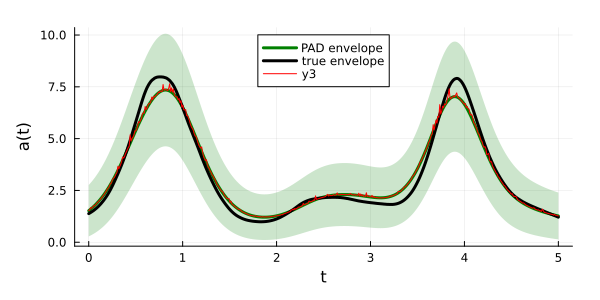

In [21]:
plot(time_range,expmgp,ribbon=sqrt.(expvgp),linewidth=3.0,label="PAD envelope",color=:green,fillalpha=0.2, size = (600, 300),margin=5Plots.mm)
plot!(time_range,exp.(amplitude_gt), label="true envelope",linewidth=3.0,color=:black,legend=:top)
plot!(time_range,mean_a,color=:red, label="exp(amplitude)")
ylabel!("a(t)")
xlabel!("t")

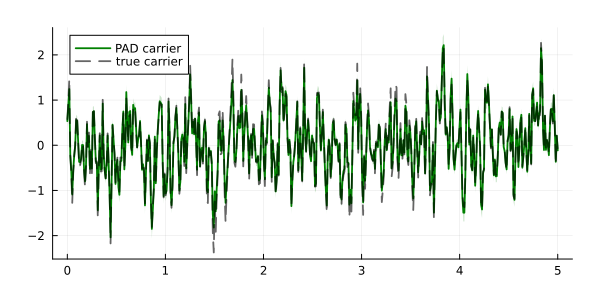

In [22]:
plot(time_range, PAD_carrier_synthetic,ribbon=sqrt.((var_PAD_carrier)),label="PAD carrier",linewidth=1.8,color=:green, fillalpha=0.2, size=(600,300),margin=5Plots.mm)
plot!(time_range, carrier_gt,linewidth=1.8, label="true carrier",alpha=0.6,ls=:dash, legend=:topleft,color=:black)

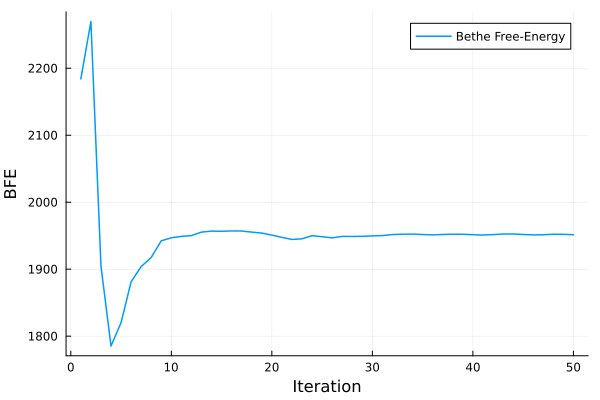

In [23]:
plot(iresult.free_energy, lw=1.5, label="Bethe Free-Energy")
xlabel!("Iteration")
ylabel!("BFE")

In [24]:
function SNR(signal, noise)
    N = length(signal)
    P_signal = sum(abs.(signal).^2) / N
    P_noise = sum(abs.(noise).^2) / N

    return 10*log10(P_signal / P_noise)
end

SNR (generic function with 1 method)

In [25]:
gt_envelope = exp.(amplitude_gt);
PAD_env_error = gt_envelope - expmgp;
PAD_env_SNR = SNR(expmgp,PAD_env_error)

20.218766372985314

In [26]:
PAD_carrier_error = carrier_gt - PAD_carrier_synthetic;
PAD_carrier_SNR = SNR(PAD_carrier_synthetic, PAD_carrier_error)

16.964294633214966

## Real Data 

In [27]:
using WAV, MAT, DSP, FFTW

In [28]:
datapath = "/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/data/"
file = matopen(datapath*"filter_outputs.mat")
FilteredOutput = read(file, "data")

X, fs = wavread(datapath*"data_05-Bubblingstream.wav");
fs = Float64(fs);

In [30]:
data = FilteredOutput[:,2];
NumberOfSamples = length(data);
signal_time = 1/fs * (NumberOfSamples-1);
signaltime_range = collect(0.:1/fs:signal_time); 
data = data / sqrt(var(data));

# #Let's use 1 second of the signal 
NumberOfTruncatedSignalSamples = Int(round(fs+1))
y_data = data[1:NumberOfTruncatedSignalSamples] 
t_data = collect(0.:1/fs:(NumberOfTruncatedSignalSamples-1) / fs);

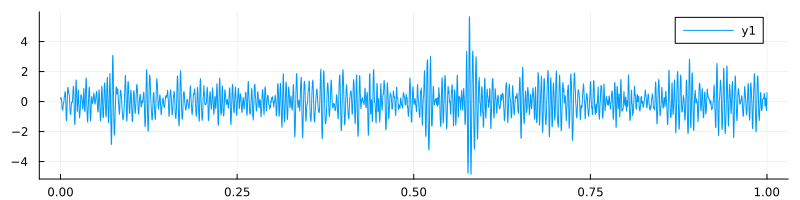

In [31]:
from = 1 
to = length(y_data)
skip = 1

plot(t_data,y_data,size = (800,200))

In [32]:
#GP Amplitude Demodulation model 
@model function gp_AmplitudeDemodulation(n, P∞_amplitude,A_amplitude,Q_amplitude,P∞_carrier,A_carrier,Q_carrier,H)
    y = datavar(Float64,n)
    f = randomvar(n)
    z = randomvar(n)
    g = randomvar(n)
    c = randomvar(n)
    # w = randomvar(n)
    d = randomvar(n)
    
    f_0 ~ MvNormalMeanCovariance(zeros(length(H)), P∞_amplitude)
    c_0 ~ MvNormalMeanCovariance(zeros(length(H)), P∞_carrier)
    f_prev = f_0
    c_prev = c_0
    for i=1:n 
        f[i] ~ MvNormalMeanCovariance(A_amplitude[i] * f_prev, Q_amplitude[i])
        z[i] ~ NormalMeanVariance(dot(H , f[i]), 1.)
        g[i] ~ MyExponential(z[i]) 

        c[i] ~ MvNormalMeanCovariance(A_carrier[i] * c_prev, Q_carrier[i])
        d[i] ~ NormalMeanVariance(dot(H, c[i]),1.) 

        y[i] ~ (*)(d[i],g[i]) where {meta = TinyCorrection(), pipeline = RequireMessage(A = NormalMeanPrecision(0.,10.),in = LogNormal(0,2))}
        f_prev = f[i]
        c_prev = c[i]
    end
end

In [81]:
#### compute matrices for the state-space model corresponding to Matern-52 kernel ######
θ_amplitude = [0.021, 1.]; # store [l, σ²]
θ_carrier = [0.0001, .02]; # store [l, σ²]

Δt = [t_data[2] - t_data[1]]; # time difference
append!(Δt, t_data[2:end] - t_data[1:end-1]);

λ_amplitude = sqrt(5)/θ_amplitude[1];
λ_carrier = sqrt(5)/θ_carrier[1];

L = [0., 0., 1.];
H = [1., 0., 0.];

F_amplitude = [0. 1. 0.; 0. 0. 1.;-λ_amplitude^3 -3λ_amplitude^2 -3λ_amplitude]
F_carrier = [0. 1. 0.; 0. 0. 1.;-λ_carrier^3 -3λ_carrier^2 -3λ_carrier]

Qc_amplitude = 16/3 * θ_amplitude[2] * λ_amplitude^5;
Qc_carrier = 16/3 * θ_carrier[2] * λ_carrier^5;

Imat = diageye(3) ; 

vec_P_amplitude = inv(kron(Imat,F_amplitude) + kron(F_amplitude,Imat)) * vec(-L * Qc_amplitude * L'); 
vec_P_carrier = inv(kron(Imat,F_carrier) + kron(F_carrier,Imat)) * vec(-L * Qc_carrier * L'); 

P∞_amplitude = reshape(vec_P_amplitude,3,3);
P∞_carrier = reshape(vec_P_carrier,3,3);

A_amplitude = [exp(F_amplitude * i) for i in Δt]; 
Q_amplitude = [P∞_amplitude - i*P∞_amplitude*i' for i in A_amplitude];

A_carrier = [exp(F_carrier * i) for i in Δt]; 
Q_carrier = [P∞_carrier - i*P∞_carrier*i' for i in A_carrier];

In [91]:
nits =10

iresult = inference(
    model = gp_AmplitudeDemodulation(length(y_data), P∞_amplitude,A_amplitude,Q_amplitude, P∞_carrier,A_carrier,Q_carrier,H),
    iterations = nits, 
    data  = (y = y_data,),
    returnvars = (f = KeepLast(),c = KeepLast(),),
    options = (limit_stack_depth=100,),
    free_energy = true,
)

Inference results:
  Posteriors       | available for (f, c)
  Free Energy:     | Real[1.20097e5, 99650.3, 1.16238e5, 1.10495e5, 110834.0, 1.10716e5, 1.10745e5, 1.10806e5, 1.10856e5, 1.10908e5]


In [92]:
mgp = mean.(iresult.posteriors[:f]) |> slicedim(1)
vgp = var.(iresult.posteriors[:f]) |> slicedim(1)
expvgp = exp.( mgp .+ vgp)
expmgp = exp.(mgp);

mcarriers = mean.(iresult.posteriors[:c]) |> slicedim(1)
vcarriers = var.(iresult.posteriors[:c]) |> slicedim(1);

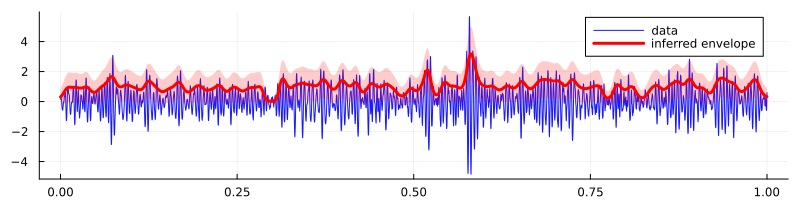

In [93]:
plot(t_data,y_data, label="data",alpha=0.9,ms=3, color=:blue)
plot!(t_data,expmgp,ribbon=sqrt.(expvgp),linewidth=3.0,label="inferred envelope",fillalpha=0.2,color=:red, size=(800,200))
# plot!(t_data,y_data, label="data",alpha=0.9,ms=3, color=:blue)

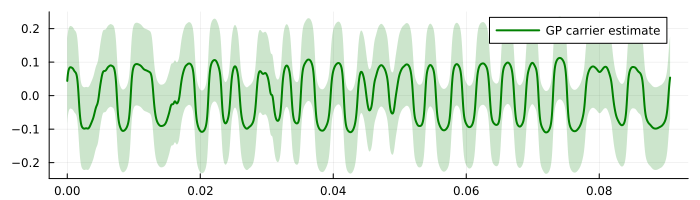

In [94]:
plot(t_data[1:2000], mcarriers[1:2000],ribbon=sqrt.((vcarriers[1:2000])),label="GP carrier estimate",linewidth=2.0, fillalpha=0.2, color="green", size=(700,200))

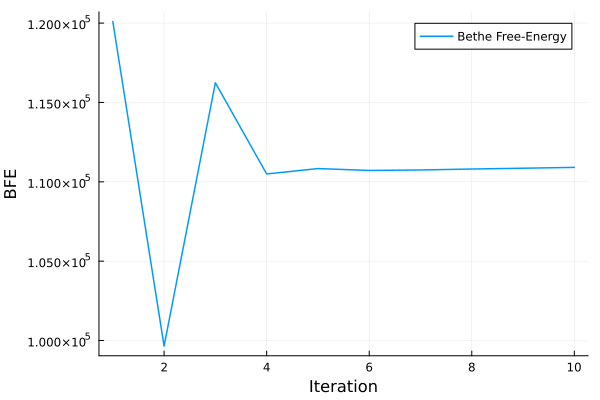

In [95]:
plot(iresult.free_energy, lw=1.5, label="Bethe Free-Energy")
xlabel!("Iteration")
ylabel!("BFE")

## Generate sound

In [299]:
envelope_mat = hcat(envelope...) 
carrier_mat = hcat(carrier...);

sound = sum(envelope_mat .* carrier_mat,dims=2);

In [300]:
wavwrite(sound,"Generated_bubblingstream.wav";Fs=22000)

In [257]:
amplitude_est = mean.(iresult.posteriors[:f])
var_amplitude_est = vgp = cov.(iresult.posteriors[:f]);
carrier_est = mean.(iresult.posteriors[:c]); 
var_carrier_est = cov.(iresult.posteriors[:c]);
transition(m_prev,V_prev,A,Q) = (A*m_prev, A * V_prev * A' + Q);
measurement(m,V) = (dot(H,m), dot(H,V,H) + 0.6);
exp_measurement(m,v) = (exp(m + v/2), (exp(v)-1)*exp(2*m + v));
prodmessages(m1,v1,m2,v2) = (m1*m2,v1*v2 + v2*m1^2 + v1*m2^2);

prev_amplitude_state = (0., P∞_amplitude)
prev_carrier_state = (0., P∞_carrier) 


(0.0, [0.500000000000001 -1.3463767361060352e-12 -833333.3333333343; 4.400508209317727e-13 833333.3333333343 -3.053343897441383e-7; -833333.3333333352 3.053343897441383e-7 1.2500000000000004e13])

In [258]:
var_amplitude_est[1]

3×3 Matrix{Float64}:
     0.0613228    -23.9903     -4888.45
   -23.9903     22810.3           -4.01405e6
 -4888.45          -4.01405e6      2.36741e10

In [259]:
generated_sound = zeros(length(y_data))
var_generated_sound = zeros(length(y_data))
for i=1:length(y_data)
#compute a_t 
    m_xt,v_xt = measurement(amplitude_est[i],var_amplitude_est[i]);
    m_at, v_at = exp_measurement(m_xt,v_xt);
#compute c_t
    m_ct,v_ct = measurement(carrier_est[i],var_carrier_est[i]);
#compute y_t 
    generated_sound[i],_ = prodmessages(m_at,v_at,m_ct,v_ct);
end 

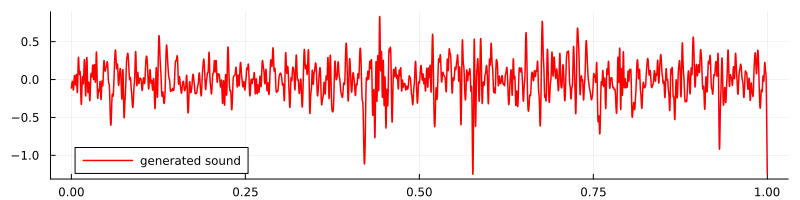

In [260]:
plot(t_data, generated_sound, linewidth=1.5,label="generated sound",fillalpha=0.2,color=:red, size=(800,200))

In [261]:
wavwrite(generated_sound,"Generated_bubblingstream.wav";Fs=22000)

In [221]:
wavwrite(y_data,"filtered_bubblingstream.wav";Fs=22000)

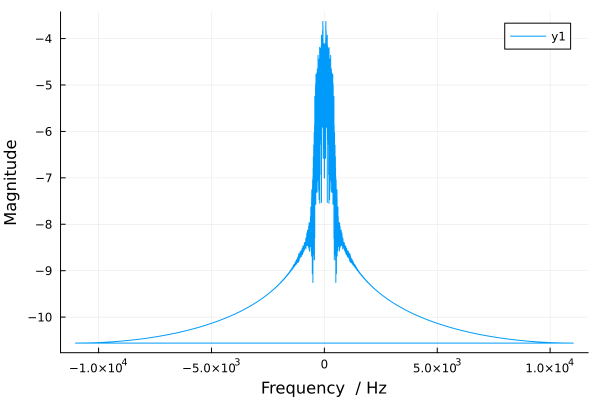

In [268]:
plot( FFTW.fftfreq(length(generated_sound), fs), log.(abs.(fft(generated_sound)./length(generated_sound))), 
                            xguide="Frequency  / Hz", yguide="Magnitude")

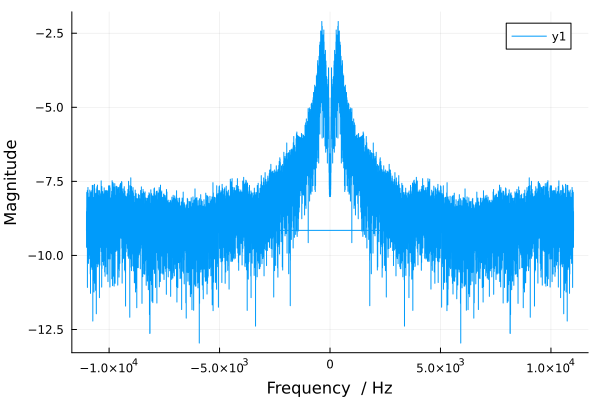

In [250]:
plot( FFTW.fftfreq(length(y_data), fs), log.(abs.(fft(y_data)./length(y_data))), 
                            xguide="Frequency  / Hz", yguide="Magnitude")

In [247]:
fieldnames(typeof(spec))

(:power, :freq, :time)